# Wilderness World Heritage analysis for the marine environment (no antarctica)
---
Based on the discussion with Bastian and various people.

The spatial analysis was done outside of this notebook. In a nutshell, the spatial component dealt with the question of how much of [cumulative marine pressure](http://www.nature.com/ncomms/2015/150714/ncomms8615/full/ncomms8615.html) there is in each unit (see below for such a hypothetical biogeographic classification). The analysis was carried out in such a way that the aggregation happens in the later stage and if thresholds are to be changed (very likely due to the explorative nature of such exercise), it requires minimum efforts without having to re-run any spatial analysis, which are time-consuming and prone to error.

Nodata in the result (when converting rasters to numpy) is also removed thus saving the efforts of having to manually remove them here.

In [1]:
# load default libraries
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# make sure gdal is correctly installed
from osgeo import gdal
import gc

%matplotlib inline

C:\Users\yichuans\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


## Get quantiles from the input raster data (global threshold from raw data)

It is necessary to load the original raster in order to calculateits quantiles. They are used to define thresholds to explore the extent of marine wilderness areas.

In [2]:
def raster2array(rasterfn):
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(1)
    return band.ReadAsArray()

In [3]:
g_array = raster2array('global_cumul_impact_2013_all_layers.tif')

In [4]:
g_array_f = g_array.flatten()

In [153]:
(g_array_f == 0).sum()

330730483

In [5]:
print('The total number of non-zero values in the raw raster dataset:', g_array_f.size - (g_array_f==0).sum())

## in fact the following should be used for testing equality of float dtypes. Because the result remains\
## the same thus the simpler option is used.

## (np.isclose(g_array_f, 0.0)).sum()

The total number of non-zero values in the raw raster dataset: 414635567


The number of non-zero values is notably different from esri's calculation, which stands at 414,347,791, less than what's calculated here and is 300,000 fewer zeros. This suggests esri may be using a bigger tolerence value, i.e. what is considered small enough to be regarded as zero .

Now, get the quantiles... this threshold is subject to change. For the time being, arbitary values of 1%, 3%, 5% and 10% are used.

In [6]:
## the percentile function applied to the sliced array, i.e., those with values greater than 0
quantiles = [np.percentile(g_array_f[~(g_array_f == 0)], quantile) for quantile in [1,3,5,10]]

In [7]:
quantiles

[0.67987793684005737,
 1.2613298869132996,
 1.5064566135406494,
 1.8049463033676147]

In [11]:
print('\n'.join(['Threshold cut-off value: '+ str(threshold) for threshold in quantiles]))


Threshold cut-off value: 0.67987793684
Threshold cut-off value: 1.26132988691
Threshold cut-off value: 1.50645661354
Threshold cut-off value: 1.80494630337


---

## Overlap between biogeography and marine pressure (global threshold)

The hypothetical biogeographical classification of the marine environmental within EEZ is described as a combination of MEOW (Marine Ecoregional of the World), its visual representation (called hereafter MEOW visual) up to 200 nautical miles and the World's pelagic provinces. The spatial data was prepared in a way such that from the coastline outwards disjoint polygons represents: MEOW (up to 200 meter depth, inner/red), MEOW visual overlaps with pelagic provinces (middle/green), pelagic provinces that do not overlap with MEOW visual (outer/blue). This is purely a spatial aggregation based on the above data and the World Vector Shoreline EEZ. See below for example.

![title](classification.PNG)

Load the `input_data` table, which describes the intersection between the marine pressure layer and the marine ecoregion/pelagic provinces classification. The `input_attr` table contains information on the relationship between `OBJECTID` and each raster pixel value.
- `OBJECTID` (one) - pixel value (many)
- `OBJECTID` (many) - attr: Province, Ecoregion, and Realm, categories (one)
Each pixel is of height and width: 934.478 meter, making each pixel in area 0.873 $km^2$

In [8]:
# calculate cell-size in sqkm2
cell_size = 934.478*934.478/1000000
print(cell_size)

0.8732491324839999


In [47]:
# the OBJECTID - ras_val table. This is a very big table and will take a long time.
input_data = pd.read_csv('result.csv')
# print fields
input_data.columns

Index(['OBJECTID', 'ras_val'], dtype='object')

In [152]:
input_data.ras_val.min()

2.9654e-06

In [48]:
# the attribute table containing information about province etcb
input_attr = pd.read_csv('attr.csv')
# print fileds
input_attr.columns

Index(['OBJECTID', 'PROVINCE_P', 'BIOME_P', 'REALM_P', 'ECO_CODE', 'ECOREGION',
       'PROV_CODE', 'PROVINCE', 'RLM_CODE', 'REALM', 'ALT_CODE', 'ECO_CODE_X',
       'category', 'Shape_Length', 'Shape_Area'],
      dtype='object')

In [12]:
# total count of pixels per OBJECTID, i.e. base
result_count = input_data.groupby('OBJECTID').count().reset_index()

Here I created four result tables containing only pixels that meet the criteria as specified by different thresholds

In [13]:
# filter result only in the top 1, 3, 5, 10 percentile (of least impacted marine areas)
result_1, result_3, result_5, result_10 = \
[input_data[input_data.ras_val <= threshold].groupby('OBJECTID').count().reset_index() for threshold in quantiles]

The next step will be to join the `input_attr` table with filtered pixel values. Replace `result10` result table if other threshold is used.

In [49]:
# join base to the attribute
attr_merge = pd.merge(input_attr, result_count, on = 'OBJECTID')

# join result to the above table
attr_merge_10 = pd.merge(attr_merge, result_10, how = 'left', on ='OBJECTID', suffixes = ('_base', '_result'))

# fill ras_val_result's NaN with 0, province and realms with None. This should happen earlier
attr_merge_10['ras_val_result'].fillna(0, inplace=True)
attr_merge_10['PROVINCE'].fillna('None', inplace=True)
attr_merge_10['PROVINCE_P'].fillna('None', inplace=True)

# apply an aggregate function to each sub dataframe, as a result of grouping
def apply_func(group):
    overlap = group['ras_val_result'].sum()*cell_size # in sqkm
    base = group['ras_val_base'].sum()*cell_size
    per = overlap/base
    # can have multiple columns as a result, if returened as pd.series
    return pd.Series([overlap, per, base], index=['less_than_threshold', 'per_ltt', 'base'])

# code reuse: threshold
def calculate_wilderness_marine(threshold, groups):
    """<threshold to consider wilderness value>, <a python list such as ['PROVINCE', 'PROVINCE_P', attr fields]>"""
    # filtered input data according to threshold merge
    input_data_filtered = input_data[input_data.ras_val <= threshold].groupby('OBJECTID').count().reset_index()
    
    # base merge
    base_merge = pd.merge(input_attr, result_count, on = 'OBJECTID')
    
    # merge the two above
    result = pd.merge(base_merge, input_data_filtered, how='left', on='OBJECTID', suffixes=('_base', '_result'))
        # solve no data issue
    result['ras_val_result'].fillna(0, inplace=True)
    result['PROVINCE'].fillna('None', inplace=True)
    result['PROVINCE_P'].fillna('None', inplace=True)
    
    return result.groupby(groups).apply(apply_func).reset_index()
    

One all tables are joined - full attributes with pixel values, attributes can be used to specify groupings

In [188]:
# use 10% as threshold
calculate_wilderness_marine(quantiles[-1], ['PROVINCE', 'PROVINCE_P', 'category']).head(20)

,PROVINCE,PROVINCE_P,category,less_than_threshold,per_ltt,base
0,Agulhas,Agulhas Current,pelagic_meow_v,4.366246e+00,0.000008,5.390357e+05
1,Agulhas,Benguela Current,pelagic_meow_v,0.000000e+00,0.000000,2.824088e+04
2,Agulhas,None,meow200m,1.244380e+03,0.010160,1.224828e+05
3,Agulhas,South Central Atlantic,pelagic_meow_v,0.000000e+00,0.000000,6.505706e+02
4,Amsterdam-St Paul,None,meow200m,3.999481e+02,0.442512,9.038129e+02
5,Amsterdam-St Paul,Southern Indian Ocean,pelagic_meow_v,6.390088e+04,0.167804,3.808065e+05
6,Amsterdam-St Paul,Southern Subtropical Front,pelagic_meow_v,4.591544e+03,0.328358,1.398334e+04
7,Andaman,None,meow200m,2.069600e+03,0.006710,3.084360e+05
8,Andaman,Northern Indian Ocean,pelagic_meow_v,6.841034e+03,0.004711,1.452095e+06
9,Arctic,Arctic,pelagic_meow_v,1.989649e+06,0.573653,3.468383e+06


Further aggregation could be applied here, if needed.

---
## Overlap between biogeography and marine pressure (new threshold for within EEZ)
The World Heritage Convention currently operates only within areas under national jurisdiction, and thus high seas/ABNJ is not to be considered. It is sensible to reduce the scope of area of interest to the extent of EEZ, and accordingly adjust wilderness threshold values. 

By excluding Antartica, where significant area of wilderness exist, it should raise the bar lower for those to be considered as wilderness areas, i.e. having a higher cumulative marine pressure threshold and more areas would be 'eligible' as wilderness.

In [189]:
# check data integrity
input_data.OBJECTID.unique().size

607

In [28]:
# no zeros in the result data
input_data.ras_val.size

160682670

In [29]:
# it should not have 0, which indicates nodata in the raster data as it has been removed during the spatial analysis
input_data.ras_val.min()

2.9654e-06

In [30]:
# percentage of EEZ water in relation to the entire ocean
input_data.ras_val.size/g_array_f[~(g_array_f==0)].size

0.3875274645698689

In [31]:
# all input_data are non-zero (zero indicates land and nodata)
input_data[~(input_data.ras_val == 0)].ras_val.count() == input_data.ras_val.count()

True

In [36]:
# get threshold for 10%
new_threshold = np.percentile(input_data.ras_val, 10)
old_threshold = np.percentile(g_array_f[~(g_array_f == 0)], 10)

Use the new threshold (based on EEZ) and the function defined in the previous section to output lists of:
- all meow provinces (including both 200 meter depth and 200 nautical miles (views) - wilderness area and percentage cover
- both provinces, meow and pelagic, within EEZ - wilderness area and percentage cover

It is possible for other combinations or different threshold if required.

In [187]:
calculate_wilderness_marine(new_threshold, ['PROVINCE']).to_csv('export_meow_province.csv')
calculate_wilderness_marine(new_threshold, ['PROVINCE', 'PROVINCE_P', 'category']).to_csv('export_province_full.csv')

**The distribution of wilderness within EEZ using new threshold**
![dist-eez](dist_eez.png)

---
**distribution of percentage of wilderness (less than threshold, ltt)**

---

In [19]:
import seaborn as sns

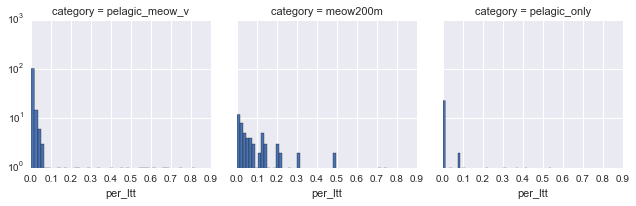

In [190]:
# small multiples: distribution of percentage of less than threshold (ltt)
g = sns.FacetGrid(calculate_wilderness_marine(new_threshold, ['PROVINCE', 'PROVINCE_P', 'category']), col="category")
g.map(plt.hist, 'per_ltt', bins=50, log=True)

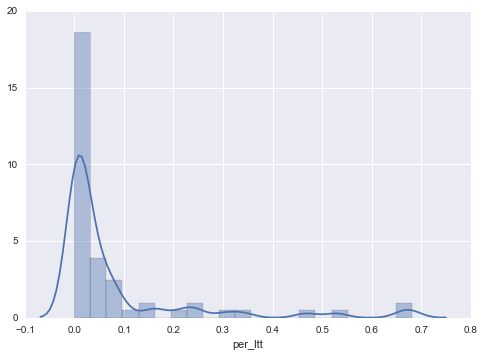

In [191]:
# MEOW province (200m and 200 nautical combined)
sns.distplot(calculate_wilderness_marine(new_threshold, ['PROVINCE']).per_ltt)

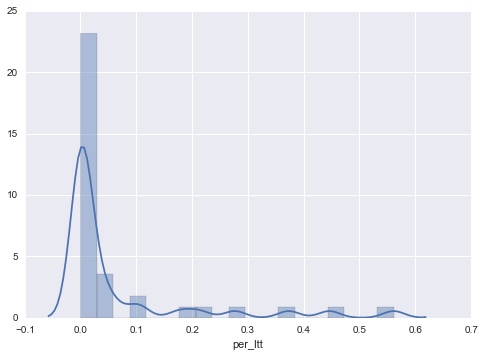

In [192]:
# pelagic province
sns.distplot(calculate_wilderness_marine(new_threshold, ['PROVINCE_P']).per_ltt)

## Overlap between marine World Heritage sites and marine pressure
The aim of this analysis is to understand wilderness marine area, as identified using methods in this study, inside the current WH sites.

In [55]:
# load data
wh47 = pd.read_csv('wh47.csv')
wh_attr = pd.read_csv('wh_attr.csv')

print(wh47.columns, wh_attr.columns)

Index(['wdpaid', 'ras_val'], dtype='object') Index(['objectid', 'wdpaid', 'en_name', 'fr_name', 'status_yr', 'rep_area',
       'gis_area', 'country', 'crit', 'shape_Length', 'shape_Area'],
      dtype='object')


In [37]:
# check thresholds, use new threshold
print('Old threshold: {0}\nNew threshold: {1}'.format(old_threshold, new_threshold))

Old threshold: 1.8049463033676147
New threshold: 1.9568599999999998


In [184]:
# get WH statics
wh_n_base = (wh47.groupby('wdpaid').ras_val.count()*cell_size).reset_index()  # all marine area
wh_n = (wh47[wh47.ras_val<new_threshold].groupby('wdpaid').ras_val.count()*cell_size).reset_index() # marine wild

# merge in order to calculate percentage (% of marine wilderness in marine area of WH sites)
a = pd.merge(wh_n_base, wh_n, on='wdpaid', suffixes=('_all', '_wild'))
a = pd.merge(wh_attr, a, how='inner', on='wdpaid')
a['per'] = a.ras_val_wild/a.ras_val_all

# export save
a.to_csv('export_wh_wilderness.csv')

## Gap analysis
### 1. Mismatch of results using WH boundary alone vs WH intersections with biogeography

In [60]:
input_attr.columns, wh_attr.columns

(Index(['OBJECTID', 'PROVINCE_P', 'BIOME_P', 'REALM_P', 'ECO_CODE', 'ECOREGION',
        'PROV_CODE', 'PROVINCE', 'RLM_CODE', 'REALM', 'ALT_CODE', 'ECO_CODE_X',
        'category', 'Shape_Length', 'Shape_Area'],
       dtype='object'),
 Index(['objectid', 'wdpaid', 'en_name', 'fr_name', 'status_yr', 'rep_area',
        'gis_area', 'country', 'crit', 'shape_Length', 'shape_Area'],
       dtype='object'))

In [148]:
int_wh = pd.read_csv('wh_base_intersect.csv')
int_wh_attr = pd.read_csv('wh_base_intersect_attr.csv')

In [64]:
int_wh.columns, int_wh_attr.columns

(Index(['OBJECTID_12', 'ras_val'], dtype='object'),
 Index(['OBJECTID_12', 'wdpaid', 'en_name', 'fr_name', 'status_yr', 'rep_area',
        'gis_area', 'country', 'crit', 'unesid',
        'FID_meow_meowv_pelagic_no_antarctica', 'PROVINCE_P', 'BIOME_P',
        'REALM_P', 'ECO_CODE', 'ECOREGION', 'PROV_CODE', 'PROVINCE', 'RLM_CODE',
        'REALM', 'ALT_CODE', 'ECO_CODE_X', 'category', 'Shape_Length',
        'Shape_Area'],
       dtype='object'))

In [83]:
# filter pixels that meet the new threshold (from EEZ)
int_wh_filter = int_wh[int_wh.ras_val < new_threshold]

# group value based on OBJECTID
int_wh_filter_group = int_wh_filter.groupby('OBJECTID_12').count().reset_index()

# attr join
int_result = pd.merge(int_wh_attr, int_wh_filter_group, on='OBJECTID_12')

# % wilderness area inside each PA within EEZ
int_result.groupby(['wdpaid', 'en_name']).ras_val.sum()*cell_size

As contrary to common sense, wilderness in WH sites calculated from the intersection is slightly different from that of directly using WH boundary to cut out the marine cumulative impact data. This is due to boundary mismatches. The intersection of WH and EEZ (with biogeography attrs) removed all land area, where the marine pressure layer may have mapped pixels (See below highlighted pixels, in Galapogas)

![boundary-mismatch](mis_boundary.PNG)

Vice versa, due to the nature of intersection (clipping in strict sense), adjacent geometries having a long/shared boundary might pick up the same pixel from the base raster twice. **This should not be a problem due to very low occurence (upon manual checking) but it is possible to count the same pixel twice. This should not present a problem in most cases, although it could possibly be one if such a shared boundary is very long and complicated. **

*In order to address this issue in the future, one could revert back to the old way: using an aggregated boundary for the result, however every change will mean a complete re-run. I would still prefer the fine granular approach, which far outweighs the shortcomings - do spatial once at the finest scale and the rest would be non-spatial. Subpixel level calculation is perhaps needed to determine whether or not an overlap should be counted or left out.*

Futhermore, the mismatching issue is further plagued by spatial data quality. See below Natural System of Wrangel Island, where the blue part is the overlap between WH and biogeography

![wrangel](wrangel_island.png)

The only logical/sensible way to deal with this is to use WH calulation for its self (i.e. how much of wilderness is in WH system), while the intersection WH result for relations with biogeography.

---
**Below is an in-depth investigation but it's not required as part of the gap analysis**

---

In [118]:
# calculate total WH marine area, no filter applied
# group value based on OBJECTID
int_wh_group = int_wh.groupby('OBJECTID_12').count().reset_index()

# base 
G_base = (pd.merge(int_wh_attr, int_wh_group, on='OBJECTID_12').groupby(['wdpaid', 'en_name']).ras_val.sum()*cell_size).reset_index()
G_wh = (int_result.groupby(['wdpaid', 'en_name']).ras_val.sum()*cell_size).reset_index()

In [119]:
G_base.columns, G_wh.columns

(Index(['wdpaid', 'en_name', 'ras_val'], dtype='object'),
 Index(['wdpaid', 'en_name', 'ras_val'], dtype='object'))

In [130]:
G_result = pd.merge(G_base, G_wh, how='left', on=('wdpaid', 'en_name'))
G_result.fillna(0, inplace=True)
G_result.columns = ['wdpaid', 'en_name', 'marine_area', 'marine_wild_area']
G_result['per'] = G_result.marine_wild_area/G_result.marine_area
# G_result.to_csv('export_wh_per_.csv')

G_result

In [170]:
wh47.columns, int_wh.columns

(Index(['wdpaid', 'ras_val'], dtype='object'),
 Index(['OBJECTID_12', 'ras_val'], dtype='object'))

In [173]:
wh47_int = pd.merge(int_wh, int_wh_attr, on='OBJECTID_12')
wh47_int.columns

Index(['OBJECTID_12', 'ras_val', 'wdpaid', 'en_name', 'fr_name', 'status_yr',
       'rep_area', 'gis_area', 'country', 'crit', 'unesid',
       'FID_meow_meowv_pelagic_no_antarctica', 'PROVINCE_P', 'BIOME_P',
       'REALM_P', 'ECO_CODE', 'ECOREGION', 'PROV_CODE', 'PROVINCE', 'RLM_CODE',
       'REALM', 'ALT_CODE', 'ECO_CODE_X', 'category', 'Shape_Length',
       'Shape_Area'],
      dtype='object')

In [194]:
# compare differences from the two methods
a = wh47.groupby('wdpaid').ras_val.count().reset_index()
b = wh47_int.groupby('wdpaid').ras_val.count().reset_index()
c = pd.merge(a, b, on='wdpaid', suffixes=('_wh', '_int'))
c['per'] = abs(c.ras_val_wh - c.ras_val_int)/c.ras_val_wh
# c

There are considerable differences in percentage between the two methods to calculate marine areas within WH sites at first glance, however at the site scale, apart from wrangel Island, the differences are quite negliable. 

### 2. the gap analysis
The below is an overlay map between existing marine WH sites on top of wilderness identified.
![dist-gap](dist_EEZ_WH.png)

In [197]:
# the data to be used
## wh intersection

# filter pixels that meet the new threshold (from EEZ)
int_wh_filter = int_wh[int_wh.ras_val < new_threshold]

# group value based on OBJECTID
int_wh_filter_group = int_wh_filter.groupby('OBJECTID_12').count().reset_index()
# attr join
int_result = pd.merge(int_wh_attr, int_wh_filter_group, on='OBJECTID_12')
int_result.columns

Index(['OBJECTID_12', 'wdpaid', 'en_name', 'fr_name', 'status_yr', 'rep_area',
       'gis_area', 'country', 'crit', 'unesid',
       'FID_meow_meowv_pelagic_no_antarctica', 'PROVINCE_P', 'BIOME_P',
       'REALM_P', 'ECO_CODE', 'ECOREGION', 'PROV_CODE', 'PROVINCE', 'RLM_CODE',
       'REALM', 'ALT_CODE', 'ECO_CODE_X', 'category', 'Shape_Length',
       'Shape_Area', 'ras_val'],
      dtype='object')

In [198]:
int_result.groupby('PROVINCE').wdpaid.count()

PROVINCE
Arctic                               2
Central Polynesia                    5
Cold Temperate Northeast Pacific     2
Cold Temperate Northwest Pacific     1
East Central Australian Shelf        1
Eastern Coral Triangle               1
Galapagos                            8
Hawaii                               4
Java Transitional                    1
Lusitanian                           1
Magellanic                           1
Mediterranean Sea                    1
Northeast Australian Shelf           8
Northern European Seas               4
Northwest Australian Shelf           1
Red Sea and Gulf of Aden             1
South China Sea                      1
Southern New Zealand                 1
Subantarctic Islands                 8
Subantarctic New Zealand            15
Tristan Gough                        1
Tropical East Pacific               11
Tropical Northwestern Atlantic       1
Tropical Northwestern Pacific        1
Tropical Southwestern Atlantic       1
Tropical Southwe